In [1]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
seed = 0
np.random.seed(seed)

## Fetch the jet tagging dataset from Open ML (run this only once, this can take a while)

In [2]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']

In [3]:
le = LabelEncoder()
yl = le.fit_transform(y)
yc = to_categorical(yl, len(le.classes_))

In [4]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, yc, test_size=0.2, random_state=42)

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score
import setGPU

setGPU: Setting GPU to: 2


In [6]:
def History(label, h):
    plt.plot( h.history['loss'], label ='Training Loss: {}'.format(label))
    plt.plot( h.history['val_loss'], label = 'Validation Loss: {}'.format(label))
    plt.plot( h.history['accuracy'], label = 'Training Accuracy: {}'.format(label))
    plt.plot( h.history['val_accuracy'], label = 'Validation Accuracy: {}'.format(label))
    plt.legend()
    plt.show()

In [7]:
def Accuracy(m):
    pred = m.predict( X_test)
    a = accuracy_score(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
    print("Accuracy: {}: {}".format(m.name, a))
    return pred, a

## Construct a simple dense model

We'll use 3 hidden layers with 32, then 64, then 64 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense, Activation, BatchNormalization, Conv1D, Dropout, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1

In [9]:
def get_model(label=""):
    i = Input(shape=(16,))
    d = Dense(32, name='fc1', activation='relu')(i)
    d = Dense(64, name='fc2', activation='relu')(d)
    d = Dense(64, name='fc3', activation='relu')(d)
    o = Dense(len(le.classes_), activation='softmax', name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001))(d)
    model = Model(inputs=i, outputs=o, name='model_DNN{}'.format(label))
    model.summary()
    model.compile(optimizer=Adam(lr=0.0001), loss=['categorical_crossentropy'], metrics=['accuracy'])
    return model

## Train the model
with an increasing amount of the training dataset, reporting the performance on the fixed test dataset

In [10]:
n_steps = 10
increase_factor = 2

In [11]:
start_size = int(X_train_val.shape[0] / (increase_factor**(n_steps-1)))
steps = np.asarray(range(n_steps) )
n_samples = start_size*(increase_factor**steps)
fractions = n_samples / max(n_samples)

In [12]:
accuracies=[]
histories=[]
models=[]
for i_step,n_sub_sample in enumerate(n_samples):
        models.append( get_model("_{}".format(i_step)) )
        print("training on {} random samples".format(n_sub_sample ))
        sub_sample = np.random.choice(range(X_train_val.shape[0]), n_sub_sample)
        histories.append(models[-1].fit( X_train_val[sub_sample], y_train_val[sub_sample], batch_size=1024,
                        epochs=40, validation_split=0.25, shuffle=True) )
        _, a = Accuracy(models[-1])
        accuracies.append( a )

Model: "model_DNN_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
fc1 (Dense)                  (None, 32)                544       
_________________________________________________________________
fc2 (Dense)                  (None, 64)                2112      
_________________________________________________________________
fc3 (Dense)                  (None, 64)                4160      
_________________________________________________________________
output (Dense)               (None, 5)                 325       
Total params: 7,141
Trainable params: 7,141
Non-trainable params: 0
_________________________________________________________________
training on 1296 random samples
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 8.4446 - accuracy:

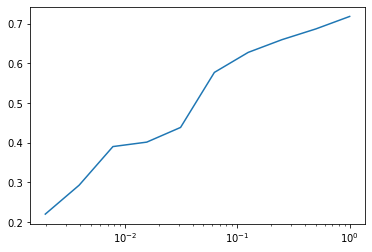

In [13]:
plt.plot(fractions,accuracies)
plt.xscale('log')
plt.show()

The non-zero derivative might indicate that this model type is not reaching its best performance, because it could use more data for training

# Exercise:
reproduce this with proper convergence using callbacks

In [14]:
from tensorflow.keras.callbacks import Callback, EarlyStopping,History,ModelCheckpoint,TensorBoard,ReduceLROnPlateau

In [15]:
accuracies=[]
histories=[]
models=[]
for i_step,n_sub_sample in enumerate(n_samples):
        models.append( get_model("_{}".format(i_step)) )
        print("training on {} random samples".format(n_sub_sample ))
        sub_sample = np.random.choice(range(X_train_val.shape[0]), n_sub_sample)
        stopping = EarlyStopping(monitor='val_loss', 
                         patience=10, 
                         verbose=1, mode='min')
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, 
                              mode='min', verbose=1, min_delta=0.001,
                              cooldown=4, min_lr=1e-5)
        histories.append(models[-1].fit( X_train_val[sub_sample], y_train_val[sub_sample], batch_size=1024,
                                        epochs=40, validation_split=0.25, shuffle=True,
                                        callbacks = [ stopping,reduce_lr ]) )
        _, a = Accuracy(models[-1])
        accuracies.append( a )

Model: "model_DNN_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 16)]              0         
_________________________________________________________________
fc1 (Dense)                  (None, 32)                544       
_________________________________________________________________
fc2 (Dense)                  (None, 64)                2112      
_________________________________________________________________
fc3 (Dense)                  (None, 64)                4160      
_________________________________________________________________
output (Dense)               (None, 5)                 325       
Total params: 7,141
Trainable params: 7,141
Non-trainable params: 0
_________________________________________________________________
training on 1296 random samples
Epoch 1/40
1/1 [==============================] - 0s 169ms/step - loss: 7.2880 - accura

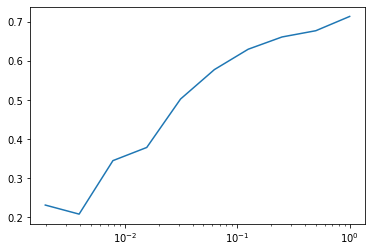

In [16]:
plt.plot(fractions,accuracies)
plt.xscale('log')
plt.show()

# Exercise:
reproduce this with error bars (K-folding)

# Challenge:
Can one predict the asymptotic performance from the performance at smaller training dataset size